---
layout: page
title: O Teorema Central do Limite
nav_order: 18
---
[<img src="https://raw.githubusercontent.com/flaviovdf/fcd/master/assets/colab_favicon_small.png" style="float: right;">](https://colab.research.google.com/github/flaviovdf/fcd/blob/master/_lessons/18-TCL.ipynb)

# Tópico 18 – O Teorema Central do Limite
{: .no_toc .mb-2 }

Na sequência do que aprendemos sobre a distribuição Normal, vamos ver nessa aula um resultado impressionante que motiva o uso dessa distribuição na grande maioria das aplicações em Ciência de Dados: O Teorema Central do Limite. Em linhas gerais, esse resultado diz que, ainda que a distribuição populacional na qual estamos interessados não seja aproximadamente Normal, a distribuição da média de uma amostra tomada dessa distribuição vai ser, sob condições muito razoáveis, aproximadamente Normal. Além disso, o resultado corrobora nossa intuição de que, quanto maior o tamanho da amostra sob a qual a média amostral é calculada, mais precisa é nossa estimativa e melhor é a aproximação resultante.   
{: .fs-6 .fw-300 }

{: .no_toc .text-delta }
Resultados Esperados

1. Introduzir o Teorema Central do Limite (TCL).
1. Aprender a utilizar o TCL para fazer Inferência, em particular para calcular probabilidades e construir intervalos de confiança.
1. Discutir a influência do tamanho amostral em nossas estimativas, e comparar os prós e contras de se utilizar o bootstrap e o TCL nesse contexto. 

{: .no_toc .text-delta }
Material Adaptado do [DSC10 (UCSD)](https://dsc10.com/)

In [1]:
import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from scipy import stats

np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option("display.max_rows", 7)
pd.set_option("display.max_columns", 8)
pd.set_option("display.precision", 2)

# Animations
import time
from IPython.display import display, HTML, IFrame, clear_output
import ipywidgets as widgets

import warnings
warnings.filterwarnings('ignore')

def normal_curve(x, mu=0, sigma=1):
    return (1 / np.sqrt(2 * np.pi * sigma ** 2)) * np.exp((- (x - mu) ** 2) / (2 * sigma ** 2))

def normal_area(a, b, bars=False, title=None):
    x = np.linspace(-4, 4)
    y = normal_curve(x)
    ix = (x >= a) & (x <= b)
    plt.plot(x, y, color='black')
    plt.fill_between(x[ix], y[ix], color='gold')
    if bars:
        plt.axvline(a, color='red')
        plt.axvline(b, color='red')
    if title:
        plt.title(title)
    else:
        plt.title(f'Area between {np.round(a, 2)} and {np.round(b, 2)}')
    plt.show()
    
def area_within(z):
    title = f'Proportion of values within {z} SDs of the mean: {np.round(stats.norm.cdf(z) - stats.norm.cdf(-z), 4)}'
    normal_area(-z, z, title=title)   
    
def show_clt_slides():
    src = "https://docs.google.com/presentation/d/e/2PACX-1vTcJd3U1H1KoXqBFcWGKFUPjZbeW4oiNZZLCFY8jqvSDsl4L1rRTg7980nPs1TGCAecYKUZxH5MZIBh/embed?start=false&loop=false&delayms=3000&rm=minimal"
    width = 960
    height = 509
    display(IFrame(src, width, height))
    
def estimate_z():
    z = widgets.FloatSlider(value=2, min=0,max=4,step=0.05, description='z')
    ui = widgets.HBox([z])
    out = widgets.interactive_output(area_within, {'z': z})
    display(ui, out)
    
def plot_many_distributions(sample_sizes, sample_means):
    bins = np.arange(5, 30, 0.5)
    for size in sample_sizes:
        pd.DataFrame().assign(data=sample_means[size]).plot(kind='hist', bins=bins, density=True, ec='w', title=f'Distribution of the Sample Mean for Samples of Size {size}', figsize=(8, 4))
        plt.legend('');
        plt.show()
        time.sleep(1.5)
        if size != sample_sizes[-1]:
            clear_output()

## Recapitulando: Padronização

### Unidades padronizadas

Lembre que, se $X$ é uma variável aleatória (numérica) com média $\mu$ e variância $\sigma^2$, e se $X_i$ é um valor (realização) dessa variável, então

$$\begin{align*}
    Z_i := \frac{X_i - \mu}{\sigma}
\end{align*}$$

representa $X_i$ em **unidades padronizadas**, isto é, o número de DPs $\sigma$ que $X_i$ está de sua média $\mu$ .

Na versão amostral, isto é, após coletar uma amostra $\mathbf{X} := (X_1, \ldots, X_n)$ com média $\bar{X}$ e variância $S^2$, as observações padronizadas são definidas por

\begin{align*}
    Z_i := \frac{X_i - \bar{X}}{S},
\end{align*}

com a mesma interpretação acima, mas relativa à distribuição da amostra.

### Exemplo rápido: pontuação no SAT

As notas no SAT vão de 0 a 1,600. A distribuição das notas do SAT tem uma média de 950 e um desvio padrão de 300. 

Se um amigo te diz que ele tirou 2.5 no SAT (em unidades padronizadas), o que você conclui?

## O Teorema Central do Limite

### Atrasos de vôos (mais uma vez) ✈️

A distribuição dos atrasos de vôos que analisamos anteriormente _não é_ aproximadamente Normal.

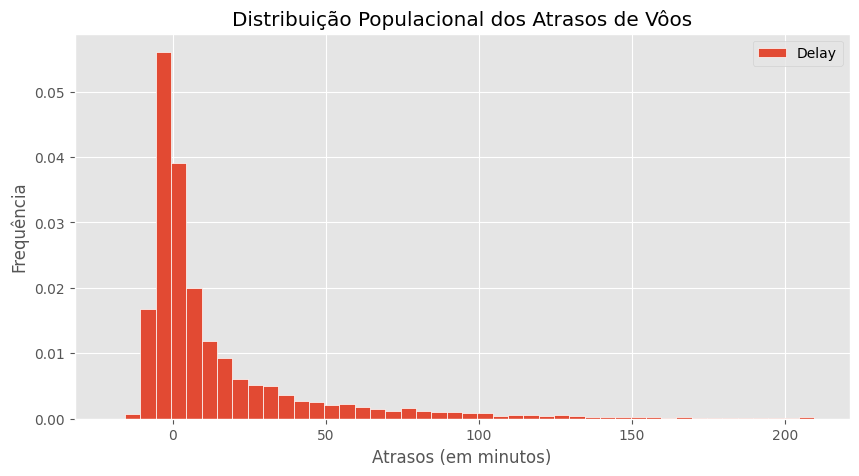

In [2]:
delays = pd.read_csv('https://raw.githubusercontent.com/flaviovdf/fcd/master/assets/17-Normalidade/data/united_summer2015.csv')
delays.plot(kind='hist', y='Delay', bins=np.arange(-20.5, 210, 5), density=True, ec='w', figsize=(10, 5), title='Distribuição Populacional dos Atrasos de Vôos')
plt.xlabel('Atrasos (em minutos)')
plt.ylabel("Frequência");

In [3]:
delays.get('Delay').describe()

count    13825.00
mean        16.66
std         39.48
           ...   
50%          2.00
75%         18.00
max        580.00
Name: Delay, Length: 8, dtype: float64

### Distribuição empírica de uma estatística

- Antes de apresentarmos as medidas de centralidade, dispersão e a distribuição Normal, discutimos o bootstrap.

- Mais especificamente, utilizamos o boostrap para construir uma aproximação para a **distribuição de uma estatística (por exemplo a média ou a mediana amostrais)**, com base em **uma única amostra**.

- A partir dessa distribuição (a distribuição bootstrap da estatística), construímos intervalos de confiança para o parâmetro populacional de interesse.

- No contexto dessa aula, suponha que nosso parâmetro de interesse seja a média populacional.
    - Estaremos então interessados em aproximar a **distribuição da média amostral**.

- Nessa aula, introduziremos uma técnica para aproximar a distribuição da média amostral **sem recorrermos ao bootstrap**.
    - Faremos isso com a utilização do ferramental de Inferência Estatística, desenvolvida com sólidos fundamentos matemáticos baseados na Teoria de Probabilidade.
    - Lembre da nossa discussão em sala de aula: a teoria Estatística e o ferramental matemático em geral devem **fundamentar, integrar e complementar** o que conseguimos aprender a calcular com base em métodos de simulação!

### Distribuição empírica da média amostral 

Como nesse caso específico temos acesso à população dos atrasos de vôos, inicialmente vamos aproximar a distribuição amostral da média com base na média amostral de diferentes amostras, tiradas (com reposição) da população original.

- Importante: isso **não é boostrapping!**
- Essa abordagem também **não é muito prática**.
    - Se tivéssemos acesso à população completa, não precisaríamos realizar nenhum tipo de inferência – bastaria simplesmente calcular a média populacional diretamente.

In [4]:
sample_means = np.array([])
repetitions = 2000

for i in np.arange(repetitions):
    sample = delays.sample(500) # Not bootstrapping!
    sample_mean = sample.get('Delay').mean()
    sample_means = np.append(sample_means, sample_mean)
    
sample_means

array([15.3 , 17.72, 16.83, ..., 21.45, 19.16, 16.19])

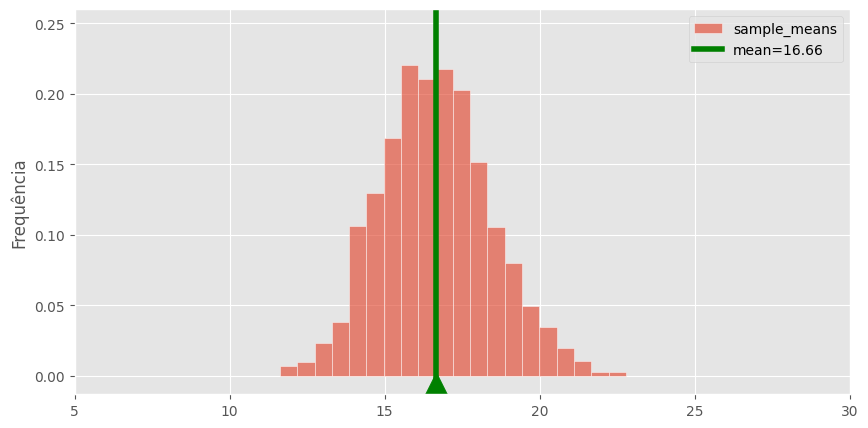

In [5]:
pd.DataFrame().assign(sample_means=sample_means).plot(kind='hist', density=True, ec='w', alpha=0.65, bins=20, figsize=(10, 5));
plt.scatter([sample_means.mean()], [-0.005], marker='^', color='green', s=250)
plt.axvline(sample_means.mean(), color='green', label=f'mean={np.round(sample_means.mean(), 2)}', linewidth=4)
plt.xlim(5, 30)
plt.ylim(-0.013, 0.26)
plt.legend()
plt.ylabel("Frequência");

Note que _essa distribuição_ é aproximadamente Normal, ainda que a _distribuição da população_ não seja.

Note ainda que a distribuição empírica das médias construída dessa maneira _está centrada na média populacional_.

### O Teorema Central do Limite

> O Teorema Central do Limite (TCL) nos diz que a distribuição de probabilidade da **média** de uma amostra de tamanho "grande o suficiente" será "sempre" aproximadamente Normal, qualquer que seja a população da qual a amostra foi retirada.

Embora as fórmulas a seguir dizem respeito ao comportamento de _médias_, os resultados do teorema são válidos também para diferentes tipos de _somas_.

### Características da distribuição da média amostral

- **Forma**: O TCL nos diz que a distribuição da média amostral será sempre aproximadamente Normal.

- **Locação**: A distribuição da média amostral vai estar **centrada** na média populacional.

- **Escala**: Discutiremos um pouco abaixo sobre a variância/desvio padrão da distribuição da média amostral.
    - Mas antes, para refletir, pense na seguinte pergunta: "Como a **dispersão** dessa distribuição seria afetada pelo tamanho amostral?"

### Influência do tamanho amostral

A função `sample_mean_delays` definida abaixo toma um argumento do tipo integer (`sample_size`), e então:
1. Toma uma amostra de tamanho $n = $ `sample_size` da população de atrasos de vôos.
2. Calcula a média amostral correspondente.
3. Repõe a amostra e itera os passos 1 a 2 acima um número $M = 2.000$ de vezes, retornando uma array com as médias amostrais de cada iteração.

In [6]:
def sample_mean_delays(sample_size):
    sample_means = np.array([])
    for i in np.arange(2000):
        sample = delays.sample(sample_size)
        sample_mean = sample.get('Delay').mean()
        sample_means = np.append(sample_means, sample_mean)
    return sample_means

In [7]:
sample_size = 100
sample_mean_delays(sample_size)

array([15.51, 18.07, 12.18, ..., 18.64, 10.85, 20.07])

Vamos agora invocar `sample_mean_delays` em um array contendo diferentes valores de `sample_size`.

In [8]:
sample_means = {}
sample_sizes = [5, 10, 50, 100, 200, 400, 800, 1600]

for size in sample_sizes:
    sample_means[size] = sample_mean_delays(size)

sample_means

{5: array([ 2.2,  5.2, -1.4, ..., 12.6,  7. ,  2.2]),
 10: array([16.7,  8.1,  3.3, ..., 11.2, 14.6, 10.3]),
 50: array([23.1 , 32.08, 13.46, ..., 15.42, 18.28,  9.58]),
 100: array([14.35, 12.96, 22.68, ..., 19.86, 27.88, 12.53]),
 200: array([15.58, 18.04, 18.18, ..., 20.93, 19.87, 15.35]),
 400: array([15.12, 14.47, 15.11, ..., 18.64, 13.8 , 16.9 ]),
 800: array([15.48, 18.99, 17.59, ..., 18.23, 16.52, 16.27]),
 1600: array([18.11, 17.27, 16.5 , ..., 16.41, 15.35, 17.11])}

Vamos agora analisar as distribuições (empíricas) das médias amostrais resultantes desse processo.

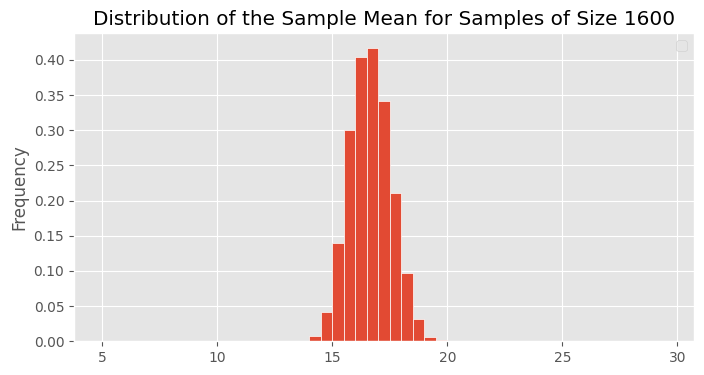

In [9]:
plot_many_distributions(sample_sizes, sample_means)

O que você consegue notar no processo acima? 🤔

### Variância da distribuição da média amostral

- À medida que o nosso tamanho amostral $n$ aumenta, a distribuição da média se torna cada vez "mais Normal", e sua variância diminui.
    - Visualmente, utilizando o que sabemos sobre a distribuição Normal, você consegue determinar aproximadamente o _quanto_ a variância diminui com o tamanho amostral?

In [10]:
# Compute the standard deviation of each distribution.
vars = np.array([])
for size in sample_sizes:
    var = np.var(sample_means[size])
    vars = np.append(vars, var)
vars

array([367.62, 159.02,  31.73,  15.25,   7.39,   3.81,   1.86,   0.78])

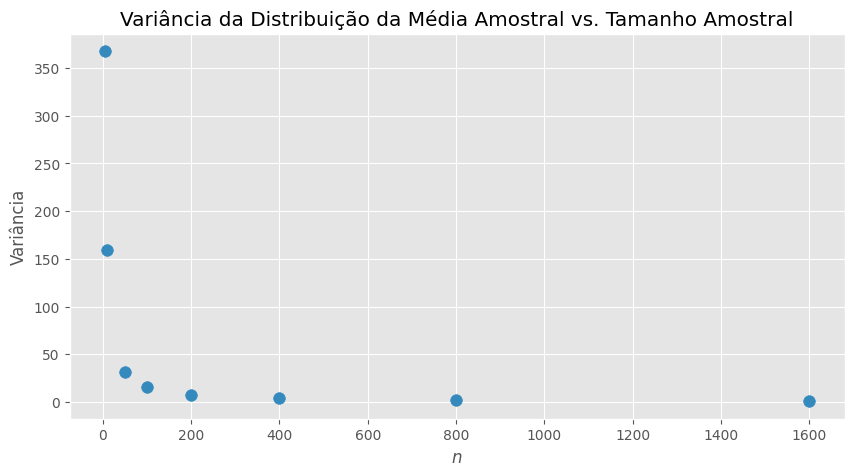

In [11]:
observed = pd.DataFrame().assign(
    SampleSize=sample_sizes,
    Variance=vars
)

observed.plot(kind='scatter', x='SampleSize', y='Variance', s=70, title="Variância da Distribuição da Média Amostral vs. Tamanho Amostral", figsize=(10, 5))
plt.xlabel("$n$")
plt.ylabel("Variância");

Aparentemente, à medida que $n$ aumenta, a variância da distribuição da média amostral diminui _drasticamente_.

### Variância da distribuição da média amostral

- À medida que aumentamos o tamanho amostral, a distribuição da média amostral fica cada vez mais "estreita", isto é, menos dispersa.
    - Em outras palavras, a distribuição da média amostral fica cada vez mais **concentrada** em torno da média populacional. 

- Mais precisamente, a lei que rege a variância das médias amostrais é do tipo

\begin{align*}
    \text{var}(\bar{X}) = \frac{\sigma^2}{n},
\end{align*}

em que $\sigma^2$ é a variância populacional.

- Em outras palavras, à medida que o tamanho amostral $n$ cresce, a variância das médias amostrais diminui de maneira _diretamente proporcional_ (i.e. _linear_).
    - Analogamente, o desvio padrão diminui com a raiz quadrada de $n$, pois aqui $\sqrt{\text{var}(\bar{X})} = \sigma/\sqrt{n}$.

Essas definições e resultados serão explicadas de maneira mais precisa em um próximo curso de Probabilidade. 

No contexto desse curso, porém, temos uma conclusão importante: quando coletamos amostras de tamanho maior, a média amostral se aproxima cada vez mais da média populacional.

> Isto é, à medida que o tamanho amostral aumenta, nossa estimativa para a média populacional se torna cada vez melhor!

- **Importante**: A afirmação acima **não** é sobre a variância ou desvio padrão _amostrais_ $S^2$ e $S$, mas sim sobre a variância/DP populacional, que é relativa à distribuição de _todas as possíveis médias amostrais_.
- Dessa forma, ao aumentar o tamanho amostral $n$:
    - **Não é verdade** ❌ que nosso DP amostral $S$ vai diminuir;
    - **É verdade** ✅ que o DP da distribuição amostral da média amostral (e que é igual ao DP populacional $\sigma$ dividido por $\sqrt{n}$) vai diminuir.

### Recapitulando: Distribuição da média amostral

- **Forma**: O TCL nos diz que a distribuição da média amostral será sempre aproximadamente Normal.

- **Locação**: A distribuição da média amostral vai estar **centrada** na média populacional.

- **Escala**: A variância da distribuição da média amostral diminui linearmente com $n$ (e o desvio padrão correspondente diminui com $\sqrt{n}$). 

**🚨 Problema**: Tanto a média quanto o desvio padrão da média amostral dependem de parâmetros da populacão original ($\mu$ e $\sigma^2$), mas na prática **não temos acesso à essa informação!**

### Boostrap vs. TCL

- Lembre que no bootstrap nosso objetivo era aproximar a distribuição de uma estatística (por exemplo, a média amostral), utilizando **simulação** e nos baseando em uma única amostra.

- O TCL descreve o comportamento a distribuição da média amostral através de uma **lei matemática**/Estatística, mas depende de informação da população ($\mu$ e $\sigma$).

- **Ideia importante**: A média $\bar{X}$ e o DP $S$ amostrais são usualmente boas aproximações para $\mu$ e $\sigma$, respectivamente. Dessa forma, podemos utilizá-los como aproximações no próprio TCL!

- Dessa forma, com base no TCL podemos **aproximar a distribuição da média amostral, com base em uma única amostra, mas sem bootstrap nem simulação!**

### Aproximando a distribuição da média amostral via bootstrap

Vamos começar tomando uma amostra de tamanho $n = 500$ do `DataFrame` `delays`.

In [12]:
np.random.seed(42)
my_sample = delays.sample(500)
my_sample.get('Delay').describe()

count    500.00
mean      13.01
std       28.00
          ...  
50%        3.00
75%       16.00
max      209.00
Name: Delay, Length: 8, dtype: float64

Para aproximar a distribuição da média amostral, podemos realizar então um bootstrap (aqui $B = 2,000$):

In [13]:
resample_means = np.array([])
repetitions = 2000

for i in np.arange(repetitions):
    resample = my_sample.sample(500, replace=True) # Bootstrapping!
    resample_mean = resample.get('Delay').mean()
    resample_means = np.append(resample_means, resample_mean)
    
resample_means

array([12.65, 11.5 , 11.34, ..., 12.59, 11.89, 12.58])

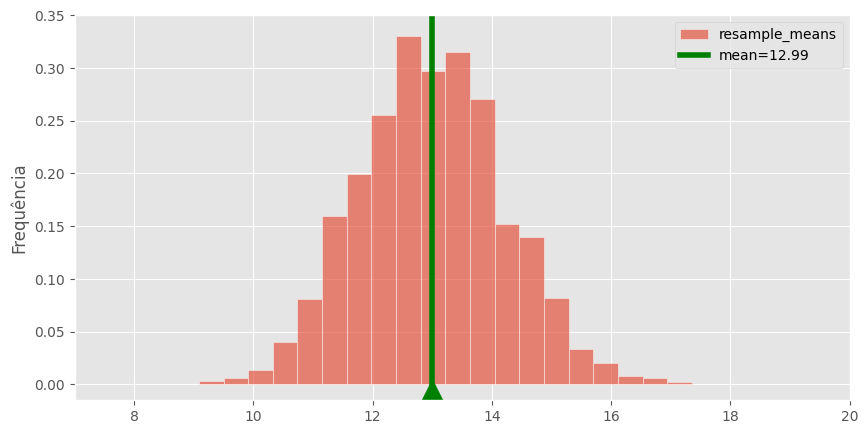

In [14]:
pd.DataFrame().assign(resample_means=resample_means).plot(kind='hist', density=True, ec='w', alpha=0.65, bins=20, figsize=(10, 5));
plt.scatter([resample_means.mean()], [-0.005], marker='^', color='green', s=250)
plt.axvline(resample_means.mean(), color='green', label=f'mean={np.round(resample_means.mean(), 2)}', linewidth=4)
plt.xlim(7, 20)
plt.ylim(-0.015, 0.35)
plt.legend()
plt.ylabel("Frequência");

### Aproximando a distribuição da média amostral com o TCL

Utilizando a média amostral $\bar{X}$ e a variância amostral $S^2$ como estimativas da média populacional $\mu$ e da variância populacional $\sigma^2$, o TCL nos diz que a distribuição da média amostral será aproximadamente Normal, centrada na própria média amostral $\bar{X}$ e com variância igual a $S^2/n$.

A média amostral de `my_sample` é igual a:

In [15]:
sample_mean_mean = my_sample.get('Delay').mean()
sample_mean_mean

13.008

e o desvio padrão correspondente é:

In [16]:
sample_mean_sd = np.std(my_sample.get('Delay')) / np.sqrt(my_sample.shape[0])
sample_mean_sd

1.2511114546674091

Vamos então elaborar o gráfico de uma curva Normal com média $\bar{X}$ e DP $S/\sqrt{n}$ e sobrepor à distribuição bootstrap obtida acima.

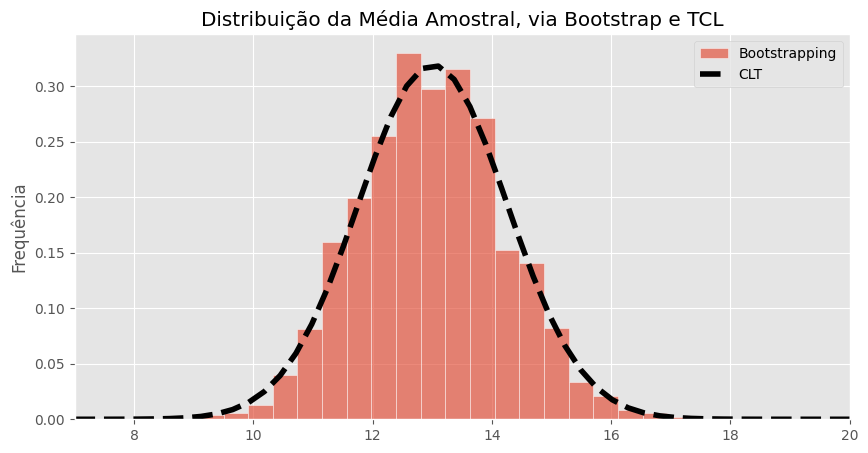

In [17]:
norm_x = np.linspace(7, 20)
norm_y = normal_curve(norm_x, mu=sample_mean_mean, sigma=sample_mean_sd)
pd.DataFrame().assign(Bootstrapping=resample_means).plot(kind='hist', density=True, ec='w', alpha=0.65, bins=20, figsize=(10, 5));
plt.plot(norm_x, norm_y, color='black', linestyle='--', linewidth=4, label='CLT')
plt.title('Distribuição da Média Amostral, via Bootstrap e TCL')
plt.xlim(7, 20)
plt.legend()
plt.ylabel("Frequência");

A aproximação é muito boa, e **sem fazer nenhuma simulação!**

In [18]:
show_clt_slides()

## Intervalos de confiança utilizando o TCL

Da mesma forma que fizemos através do bootstrap, podemos construir intervalos de confiança também com o TCL.

- Lembre que, no bootstrap, os intervalos de $\gamma\%$ de confiança são em geral calculados como os percentis $(1 - \gamma)/2$ e $(1 + \gamma)/2$ da _distribuição bootstrap_.

- Utilizando o TCL, basta pegarmos os mesmos percentis, _porém da distribuição Normal_ com média $\bar{X}$ e variância $\sigma^2/n$.

#### Intervalo de 95% de confiança via bootstrap

Com base nos resultados do bootstrap acima ($B = 2,000$), os percentis 2.5% e 97.5% da distribuição bootstrap são:

In [19]:
left_boot = np.percentile(resample_means, 2.5)
right_boot = np.percentile(resample_means, 97.5)
[left_boot, right_boot]

[10.7159, 15.43405]

Visualmente:

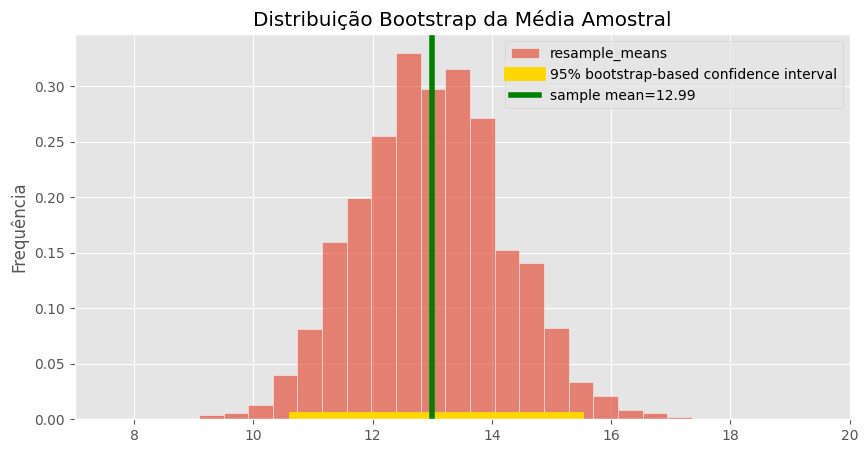

In [20]:
pd.DataFrame().assign(resample_means=resample_means).plot(kind='hist', y='resample_means', alpha=0.65, bins=20, density=True, ec='w', figsize=(10, 5), title='Distribuição Bootstrap da Média Amostral');
plt.plot([left_boot, right_boot], [0, 0], color='gold', linewidth=10, label='95% bootstrap-based confidence interval');
plt.axvline(resample_means.mean(), color='green', label=f'sample mean={np.round(resample_means.mean(), 2)}', linewidth=4)
plt.xlim(7, 20);
plt.legend()
plt.ylabel("Frequência");

#### Intervalo de 95% de confiança via TCL

Com o TCL, basta tomarmos os percentis 2.5% e 97.5% da distribuição Normal com média $\bar{X}$ e variância $S^2/n$.

A média amostral aqui é igual a

In [21]:
sample_mean_mean = my_sample.get('Delay').mean()
sample_mean_mean

13.008

E o desvio padrão amostral (dividido pela raiz do tamanho amostral) é igual a

In [22]:
sample_mean_sd = np.std(my_sample.get('Delay')) / np.sqrt(my_sample.shape[0])
sample_mean_sd

1.2511114546674091

Dessa forma, a distribuição da média amostral é, aproximadamente:

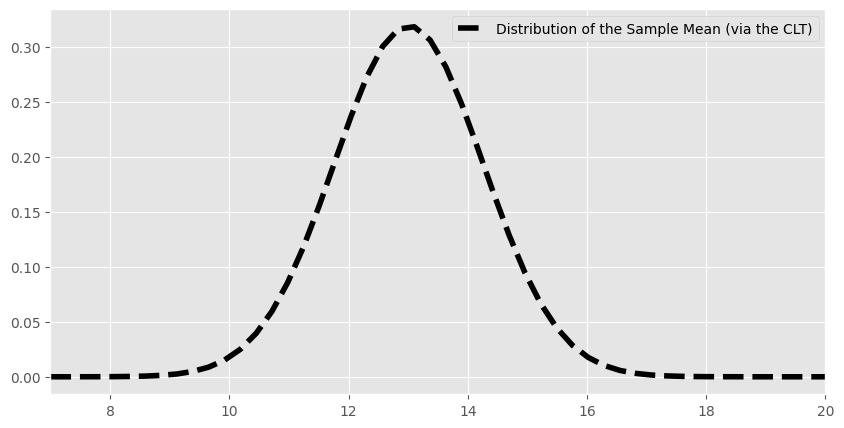

In [23]:
plt.figure(figsize=(10, 5))
norm_x = np.linspace(7, 20)
norm_y = normal_curve(norm_x, mu=sample_mean_mean, sigma=sample_mean_sd)
plt.plot(norm_x, norm_y, color='black', linestyle='--', linewidth=4, label='Distribution of the Sample Mean (via the CLT)')
plt.xlim(7, 20)
plt.legend();

- Para encontrarmos os percentis 2.5% e 97.5% dessa distribuição, lembre da última aula que, _na distribuição Normal, aproximadamente 95% dos valores estão a 2 DPs da média_.
    - Isso vale para _qualquer distribuição Normal_!

- Utilizando esse fato, como a média da distribuição acima é igual a $\bar{X}$ e seu desvio padrão é igual a $S/\sqrt{n}$, temos que o percentil 2.5% (limite inferior do IC95%) é igual a $\bar{X} - 2 \cdot S/\sqrt{n}$, e o percentil 95% (limite superior do IC95%) é igual a $\bar{X} + 2 \cdot S/\sqrt{n}$. 

In [24]:
left_normal = sample_mean_mean - 2 * sample_mean_sd
right_normal = sample_mean_mean + 2 * sample_mean_sd
[left_normal, right_normal]

[10.50577709066518, 15.510222909334818]

Visualmente:

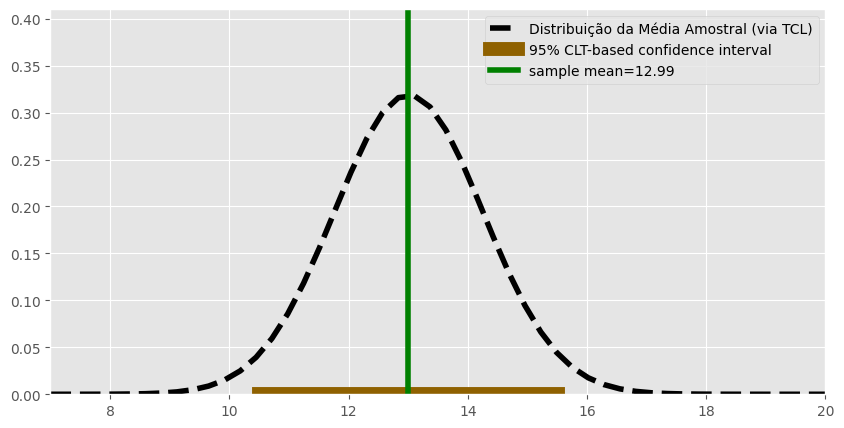

In [25]:
plt.figure(figsize=(10, 5))
norm_x = np.linspace(7, 20)
norm_y = normal_curve(norm_x, mu=sample_mean_mean, sigma=sample_mean_sd)
plt.plot(norm_x, norm_y, color='black', linestyle='--', linewidth=4, label='Distribuição da Média Amostral (via TCL)')
plt.xlim(7, 20)
plt.ylim(0, 0.41)
plt.plot([left_normal, right_normal], [0, 0], color='#8f6100', linewidth=10, label='95% CLT-based confidence interval')
plt.axvline(resample_means.mean(), color='green', label=f'sample mean={np.round(resample_means.mean(), 2)}', linewidth=4)
plt.legend();

#### Comparando os intervalos

Vamos agora comparar os ICs obtidos por ambas as técnicas!

O IC via bootstrap é dado por

In [26]:
[left_boot, right_boot]

[10.7159, 15.43405]

e o IC calculado através do TCL é dado por

In [27]:
[left_normal, right_normal]

[10.50577709066518, 15.510222909334818]

Os resultados são bem próximos!

### Resumo: IC para a média populacional via TCL

Com base no TCL, o IC95% para a média populacional é dado por

\begin{equation*}
    IC_{95\%}(\mu) = \bar{X} \pm 2 \cdot \frac{S}{\sqrt{n}} = \left[\bar{X} - 2 \cdot \frac{S}{\sqrt{n}}; \,\,\,\, \bar{X} + 2 \cdot \frac{S}{\sqrt{n}}\right].
\end{equation*}

Analogamente, para um nível $\gamma\%$ qualquer de confiança (i.e. para $0 < \gamma < 1$), temos

\begin{equation*}
    IC_{\gamma\%}(\mu) := \bar{X} \pm Z_{(1 + \gamma)/2} \cdot \frac{S}{\sqrt{n}} = \left[\bar{X} - Z_{(1 + \gamma)/2} \cdot \frac{S}{\sqrt{n}}; \,\,\,\, \bar{X} + Z_{(1 + \gamma)/2} \cdot \frac{S}{\sqrt{n}}\right],
\end{equation*}

onde $Z_{(1 + \gamma)/2}$ denota o percentil $(1 + \gamma)/2$ da distribuição _Normal padrão_.

### Observações acerca dos percentis da distribuição Normal

Se quisermos ser mais precisos, o quantil 2.5% e 97.5% da distribuição Normal padrão são, na verdade, _aproximadamente $\pm 1.96$_. 

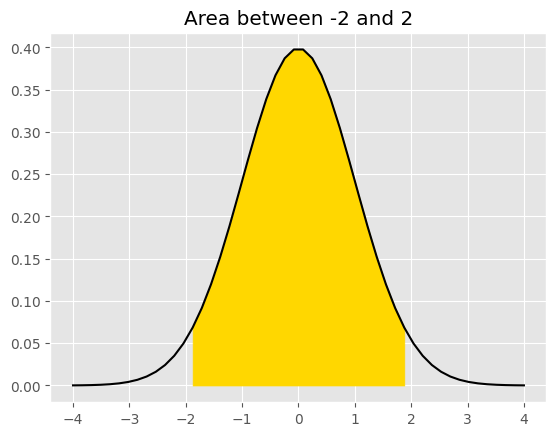

In [28]:
normal_area(-2, 2)

In [29]:
stats.norm.cdf(2) - stats.norm.cdf(-2)

0.9544997361036416

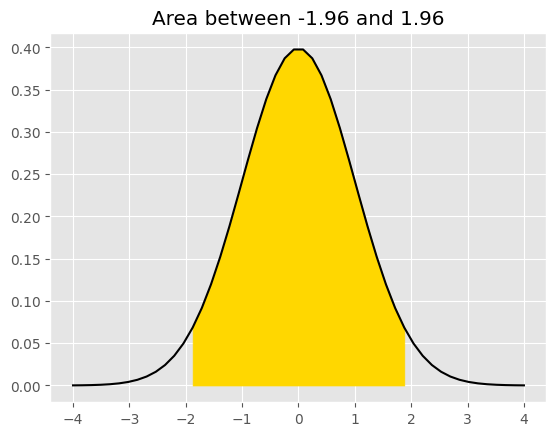

In [30]:
normal_area(-1.96, 1.96)

In [31]:
stats.norm.cdf(1.96) - stats.norm.cdf(-1.96)

0.950004209703559

Porém, na maioria dos casos, tomar $\pm 2$ leva à uma aproximação bem razoável, com uma diferença de apenas $0.45\%$ na probabilidade entre $\pm 1.96$ e $\pm 2$.

Por último, note que o intervalo definido na fórmula acima é na verdade dado por

\begin{equation*}
    \left[\bar{X} + Z_{(1 - \gamma)/2} \cdot \frac{S}{\sqrt{n}}; \,\,\,\, \bar{X} + Z_{(1 + \gamma)/2} \cdot \frac{S}{\sqrt{n}}\right].
\end{equation*}

Porém, utilizando a propriedade de reflexividade da distribuição Normal, sabemos que $Z_{(1 + \gamma)/2} > 0$ e que $Z_{(1 - \gamma)/2} = - Z_{(1 + \gamma)/2}$, de onde obtemos a forma definida anteriormente.

### E como encontramos esses percentis?

Suponha agora que, ao invés de $\gamma = 95\%$, queiramos construir um IC de $\gamma = 90\%$ de confiança.

Como podemos encontrar $Z_{(1 + \gamma)/2}$ nesse caso?

- Alternativa 1: utilizar uma tabela com a CDF da distribuição Normal padrão.
- Alternativa 2: utilizar a função `stats.norm.ppf`!

A função `stats.norm.ppf` toma um argumento `p` (uma probabilidade, e logo entre 0 e 1) e retorna o percentil equivalente ao valor de `p`.

In [32]:
stats.norm.ppf(0.9773)

2.000929388101571

In [33]:
stats.norm.ppf(1 - 0.9773)

-2.000929388101571

In [34]:
stats.norm.ppf(0.975)

1.959963984540054

In [35]:
stats.norm.ppf(1 - 0.975)

-1.959963984540054

In [36]:
round(stats.norm.ppf(0.975), 2)

1.96

In [37]:
estimate_z()

Output()

Dessa forma, se quisermos construir um IC90% para a média populacional, primeiramente calculamos os percentis 5% e 95%:

In [38]:
stats.norm.ppf(0.05)

-1.6448536269514729

In [39]:
stats.norm.ppf(0.95)

1.6448536269514722

Depois, basta substituir na fórmula que tínhamos anteriormente:

In [40]:
left_normal = sample_mean_mean - 1.64 * sample_mean_sd
right_normal = sample_mean_mean + 1.64 * sample_mean_sd
[left_normal, right_normal]

[10.956177214345448, 15.05982278565455]

In [41]:
## for more precision (and efficiency), we can simply call
left_normal = sample_mean_mean - stats.norm.ppf(0.95) * sample_mean_sd
right_normal = sample_mean_mean + stats.norm.ppf(0.95) * sample_mean_sd
[left_normal, right_normal]

[10.95010478606978, 15.065895213930219]

### Resumo: Bootstrap vs. TCL

| | Bootstrap | TCL |
| --- | --- | --- |
| **Prós** | Funciona para várias estatísticas diferentes <br> (média, mediana, desvio padrão). | Precisa de apenas 3 quantidades – <br>média amostral, DP amostral e tamanho amostral. |
| **Contras** | Computacionalmente intensivo (requer a simulação de muitas <br> e muitas amostras da amostra original). | Funciona apenas para a média/soma amostral. |

### Teste rápido ✅ 

Qual desses histogramas corresponde à distribuição da média amostral para amostras de tamanho $n = 100$ tiradas de uma população com média $\mu = 50$ e DP $\sigma = 20$??

<center><img src='https://raw.githubusercontent.com/flaviovdf/fcd/master/assets/18-TCL/images/which-histogram.png' width=900></center>

## Resumo e próxima aula

### Resumo

- O Teorema Central do Limite nos diz que a distribuição de probabilidade da **média amostral** de uma amostra com tamanho suficientemente grande será aproximadamente Normal, qualquer que seja a população original da qual a amostra é coletada.
    - Esse resultado também vale para diversos tipos de _somas_.
- O TCL também nos diz que:
    - A distribuição da média amostral será centrada na média populacional;
    - O DP da distribuição da média amostral é igual a $\sigma/\sqrt{n}$.
- Com base no TCL, podemos construir um IC de $\gamma\%$ de confiança para a média populacional $\mu$ da seguinte forma:

\begin{equation*}
    IC_{\gamma\%}(\mu) := \bar{X} \pm Z_{(1 + \gamma)/2} \cdot \frac{S}{\sqrt{n}} = \left[\bar{X} - Z_{(1 + \gamma)/2} \cdot \frac{S}{\sqrt{n}}; \,\,\,\, \bar{X} + Z_{(1 + \gamma)/2} \cdot \frac{S}{\sqrt{n}}\right],
\end{equation*}

em que $Z_{(1 + \gamma)/2}$ denota o percentil $(1 + \gamma)/2$ da distribuição _Normal padrão_.

### Próxima aula

- Discutiremos como escolher tamanhos de amostra com base na precisão desejada para nossas estatísticas0.
    - Por exemplo, se quisermos construir um IC com amplitude de _no máximo $w$_, qual o tamanho de amostra necessário para isso?
- Introduziremos noções básicas de como _testar hipóteses_ acerca da população da qual amostramos.